## Requirements

<ol>
    <li>Read Data with 
        <ul>
            <li>input:(weather parameters, NDVI, ALBEDO, LST, and their first five lags)</li>
            <li>output:(residuals, squared residual, relative residual, standardized residual)</li>
       </ul>
    </li>
    <li>Produce Density Plots between observed and predicted variable
        <ul>
            <li>observed:Ameriflux Column i.e (ET_bowen_corr(mm), ET_ebr_bowen_corr(mm), ETo, ETr)</li>
            <li>predicted:EEflux Column i.e EEflux ET, EEflux ETo, EEflux ETr</li>
       </ul>
    </li>
    <li>Produce Scatter plots witht the first bisector between x = EEflux column and y = Ameriflux Column</li>
    <li>Produce Scatter plots between x = EEflux column and y = standardized residual </li>
    <li>Produce Correlation measures between EEflux and Ameriflux Columns
     <ul>
            <li>Mutal Information</li>
            <li>Normalised Mutal Information </li>
            <li>Joint Entropy</li>
            <li>Conditional Entropy</li>
            <li>Bland Altman Plot</li>
       </ul>
    </li>
    <li>Produce Different Fitting Distributions on input and output features</li>
</ol>

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pyitlib import discrete_random_variable as drv
import pyCompare
import pingouin as pg
import statsmodels.api as sm
from nitime import algorithms
from fitter import Fitter
from fitter import get_common_distributions
from sklearn.metrics.cluster import normalized_mutual_info_score
import warnings
warnings.filterwarnings('ignore')

## 1. Loading Data set

In [2]:
base_path = "/Users/saraawad/Desktop/"
input_path = base_path + "Joint/"

In [3]:
path = input_path + "library_bowen_EEfluxET_ET.csv"
df = pd.read_csv(path, delimiter=',')
print("shape:",  df.shape)

observed_variable = "ET_bowen_corr(mm)"
predicted_variable = "EEflux ET"

df["Residual"] = df[observed_variable] - df[predicted_variable]
df["Square Residual"] = np.power((df[observed_variable] - df[predicted_variable]), 2)
df["Relative Residual"] = df[observed_variable] / df[predicted_variable]
df["Standardized Residual"] = df["Residual"]/np.std(df["Residual"])

metricsToStudy = ["Residual", "Square Residual", "Relative Residual", "Standardized Residual"]

print("columns:", df.columns)
df.head()

shape: (1239, 57)
columns: Index(['Date', 'Site Id', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH',
       'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3',
       'TA-4', 'TA-5', 'EEflux LST', 'EEflux LST-1', 'EEflux LST-2',
       'EEflux LST-3', 'EEflux LST-4', 'EEflux LST-5', 'EEflux NDVI',
       'EEflux NDVI-1', 'EEflux NDVI-2', 'EEflux NDVI-3', 'EEflux NDVI-4',
       'EEflux NDVI-5', 'EEflux Albedo', 'EEflux Albedo-1', 'EEflux Albedo-2',
       'EEflux Albedo-3', 'EEflux Albedo-4', 'EEflux Albedo-5', 'Site Id_1',
       'Site Id_2', 'Site Id_3', 'Site Id_4', 'Site Id_5', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'EEflux ET', 'EEflux ET-1',
       'EEflux ET-2', 'EEflux ET-3', 'EEflux ET-4', 'EEflux ET-5',
       'Vegetation_1', 'Vegetation_2', 'Vegetation_3', 'ET_bowen_corr(mm)',
       'Residual', 'Square Residual', 'Relative Residual',
       'Standardized Residual'],
      dtype='object')


Date Site Id        WS      WS-1      WS-2      WS-3      WS-4  WS-5  \
0    9/5/15  US-A32  4.491064       NaN       NaN       NaN       NaN   NaN   
1   9/13/15  US-A32  6.429469  4.491064       NaN       NaN       NaN   NaN   
2   9/13/15  US-A32  6.429469  6.429469  4.491064       NaN       NaN   NaN   
3  10/15/15  US-A32  5.015900  6.429469  6.429469  4.491064       NaN   NaN   
4  10/15/15  US-A32  5.015900  5.015900  6.429469  6.429469  4.491064   NaN   

          RH       RH-1  ...  EEflux ET-4  EEflux ET-5  Vegetation_1  \
0  56.219091        NaN  ...          NaN          NaN             0   
1  44.560000  56.219091  ...          NaN          NaN             0   
2  44.560000  44.560000  ...          NaN          NaN             0   
3  30.502727  44.560000  ...          NaN          NaN             0   
4  30.502727  30.502727  ...     3.442428          NaN             0   

   Vegetation_2  Vegetation_3  ET_bowen_corr(mm)  Residual  Square Residual  \
0             0             1           0.129438 -3.312990        10.975902   
1             0             1           0.200892 -1.828242         3.342467   
2             0             1           0.200892 -1.403564         1.969991   
3             0             1           0.060888 -1.133140         1.284007   
4             0             1           0.060888 -1.415762         2.004382   

   Relative Residual  Standardized Residual  
0           0.037601              -0.255670  
1           0.099004              -0.141089  
2           0.125209              -0.108316  
3           0.050993              -0.087447  
4           0.041234              -0.109257  

[5 rows x 61 columns]

In [4]:
print(df.isnull().mean() * 10)
df_all = df
df_all.dropna(subset=metricsToStudy, inplace=True)

Date                     0.000000
Site Id                  0.000000
WS                       0.000000
WS-1                     0.008071
WS-2                     0.016142
                           ...   
ET_bowen_corr(mm)        0.000000
Residual                 0.000000
Square Residual          0.000000
Relative Residual        0.008071
Standardized Residual    0.000000
Length: 61, dtype: float64


## Check for Outliers
https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

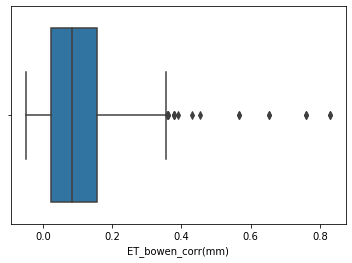

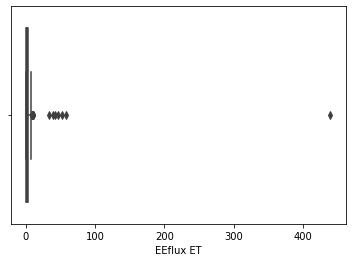

In [5]:
sns.boxplot(x=df_all[observed_variable])
plt.show()
plt.close()
sns.boxplot(x=df_all[predicted_variable])
plt.show()
plt.close()

In [6]:
Q1 = df_all.quantile(0.25)
Q3 = df_all.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

WS                        2.233521
WS-1                      2.238167
WS-2                      2.242341
WS-3                      2.246096
WS-4                      2.233521
WS-5                      2.237327
RH                       23.101903
RH-1                     23.116917
RH-2                     23.170833
RH-3                     23.188687
RH-4                     23.021288
RH-5                     23.044792
TA                       12.979750
TA-1                     12.978548
TA-2                     12.985752
TA-3                     12.992956
TA-4                     12.979048
TA-5                     13.007363
EEflux LST               15.570000
EEflux LST-1             15.540000
EEflux LST-2             15.530000
EEflux LST-3             15.540000
EEflux LST-4             15.535000
EEflux LST-5             15.560000
EEflux NDVI               0.339750
EEflux NDVI-1             0.340000
EEflux NDVI-2             0.340000
EEflux NDVI-3             0.340000
EEflux NDVI-4       

In [7]:
df_non_out = df_all[~((df_all < (Q1 - 1.5 * IQR)) |(df_all > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df_non_out.shape)

(600, 61)


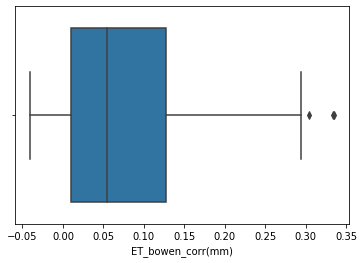

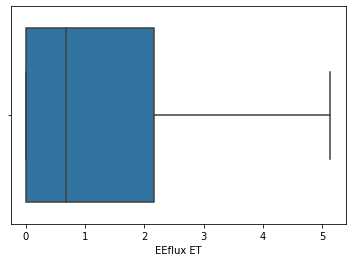

In [8]:
sns.boxplot(x=df_non_out[observed_variable])
plt.show()
plt.close()
sns.boxplot(x=df_non_out[predicted_variable])
plt.show()
plt.close()

## 2. Density Plots of Residuals
Reference: https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

In [9]:
print(df.isnull().mean() * 10)

Date                     0.000000
Site Id                  0.000000
WS                       0.000000
WS-1                     0.008078
WS-2                     0.016155
                           ...   
ET_bowen_corr(mm)        0.000000
Residual                 0.000000
Square Residual          0.000000
Relative Residual        0.000000
Standardized Residual    0.000000
Length: 61, dtype: float64


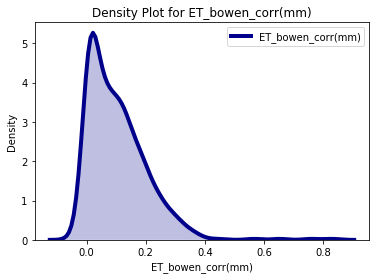

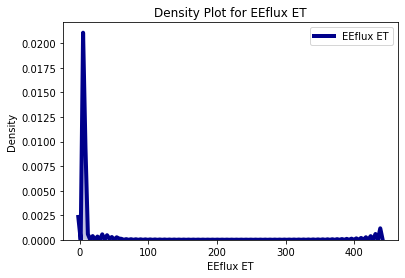

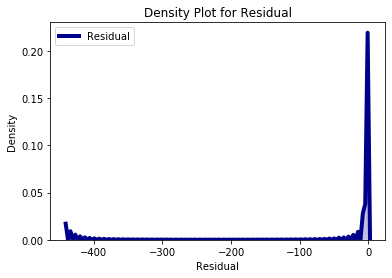

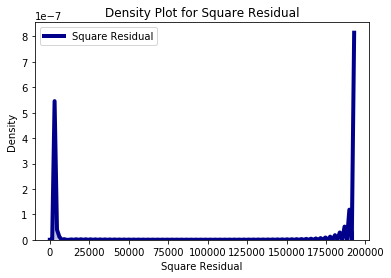

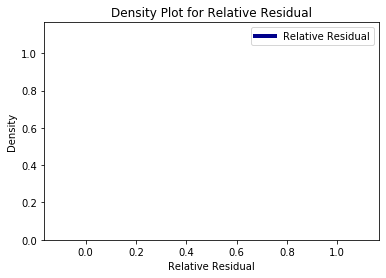

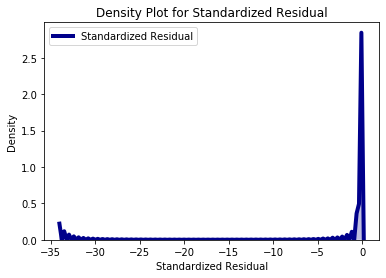

In [10]:
def density_plot(metric):
    sns.distplot(df_all[metric],
                     hist=False,
                     kde=True, 
                     rug=False,
                     color='darkblue', 
                     kde_kws={'linewidth': 4, 'shade': True},
                     rug_kws={'color': 'black'},
                     label=metric)
    plt.title('Density Plot for ' + metric)
    plt.xlabel(metric)
    plt.ylabel('Density')
    plt.show()
    plt.close()
 

columnsToPlot = [observed_variable, predicted_variable]
for metric in metricsToStudy:
    columnsToPlot.append(metric)
    
for metric in columnsToPlot:
    density_plot(metric)

## 3. Scatter Plots with bisector

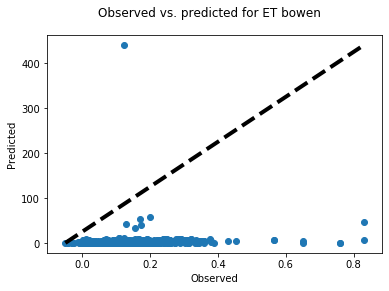

In [11]:
def plot_actual_vs_predicted_scatter_bisector(actual_column, predicted_column, name):
    fig, ax = plt.subplots()
    ax.scatter(actual_column, predicted_column)
    ax.plot([actual_column.min(), actual_column.max()],
            [predicted_column.min(), predicted_column.max()], 'k--', lw=4)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    plt.suptitle('Observed vs. predicted for ' + name)
    plt.show()
    plt.close()
    
plot_actual_vs_predicted_scatter_bisector(df_all[observed_variable], df_all[predicted_variable], 'ET bowen')

## 4. Plots Between Predicted and Standardized Residuals

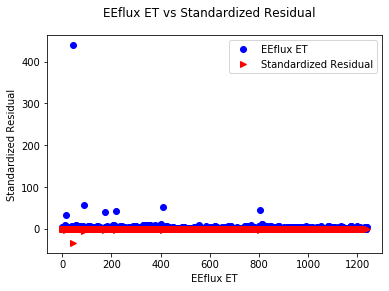

In [12]:
def plot_actual_vs_predicted(actual_column, predicted_column, columnNames):
    plt.plot(actual_column, color='b', label=columnNames[0],
            marker="o", linestyle='none')
    plt.plot(predicted_column, color='r', label=columnNames[1],
            marker=">", linestyle='none')
    plt.legend(loc='best')
    plt.xlabel(columnNames[0])
    plt.ylabel(columnNames[1])
    plt.suptitle(columnNames[0] + ' vs ' + columnNames[1])
    plt.show()
    plt.close()
    
plot_actual_vs_predicted(df_all[predicted_variable], df_all["Standardized Residual"],
                         [predicted_variable, "Standardized Residual"])


# df.plot(kind='line',x=predicted_variable,y="Standardized Residual",color='red')
# df.plot(kind='scatter',x=predicted_variable,y="Standardized Residual",color='red', marker='o')

## 5. Study Agreement

### Mutual Information
Reference: https://pafoster.github.io/pyitlib/#discrete_random_variable.entropy_pmf

Reference: https://pypi.org/project/pyitlib/

In [9]:
drv.information_mutual(df_all[observed_variable], df_all[predicted_variable], cartesian_product = True)

7.541853485680054

## Normalised Mutal Information

Reference: https://pypi.org/project/pyitlib/

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html

In [6]:
normalized_mutual_info_score(df_all[observed_variable], df_all[predicted_variable])

0.846654921158579

### Joint Entropy

Reference: https://pypi.org/project/pyitlib/

Reference: http://nipy.org/nitime/api/generated/nitime.algorithms.entropy.html

In [10]:
algorithms.entropy_cc(df_all[observed_variable], df_all[predicted_variable])

0.9201385336777129

### Conditional Entropy

In [11]:
drv.entropy_conditional(df_all[observed_variable], df_all[predicted_variable], fill_value=None)

array(2.37329914)

### Bland Altman plot / Tukey mean-difference plot
Is a statistical plotting method used to analyze the agreement between two measures

Reference: https://github.com/jaketmp/pyCompare

Reference: Bland, J. M., & Altman, D. (1986). Statistical methods for assessing agreement between two methods of clinical measurement. The lancet, 327(8476), 307-310.

Reference: https://pingouin-stats.org/generated/pingouin.plot_blandaltman.html

Reference: https://www.statsmodels.org/stable/generated/statsmodels.graphics.agreement.mean_diff_plot.html

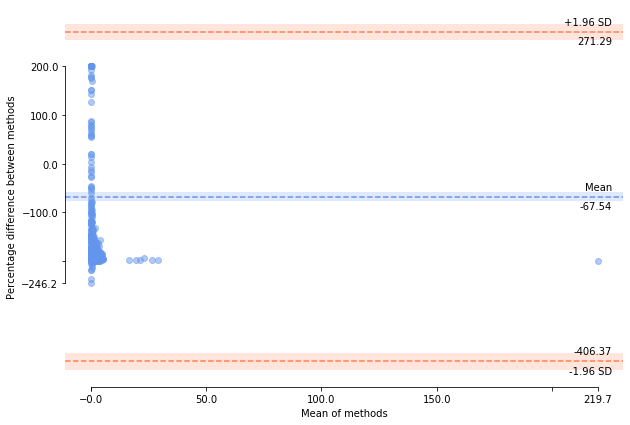

In [12]:
pyCompare.blandAltman(df_all[observed_variable],
            df_all[predicted_variable],
            limitOfAgreement=1.96,
            confidenceInterval=95,
            confidenceIntervalMethod='approximate',
            detrend=None,
            percentage=True)

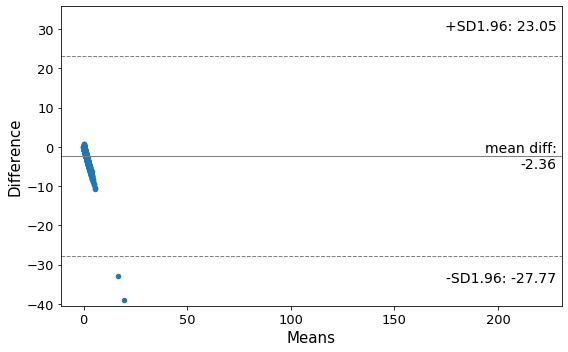

In [13]:
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(df_all[observed_variable],
            df_all[predicted_variable], ax = ax)
plt.show()

## 6. Fitting distributions
Reference: https://fitter.readthedocs.io/en/latest/references.html

Common Distributions are: ['cauchy', 'chi2', 'expon', 'exponpow', 'gamma', 'lognorm', 'norm', 'powerlaw', 'rayleigh', 'uniform', 'powerlognorm']
              sumsquare_error         aic           bic
powerlognorm         0.222337  714.046999 -10649.034598
lognorm              0.259320  712.914364 -10465.664162
chi2                 0.403759  745.657188  -9917.536315
gamma                0.403761  745.656287  -9917.527486
cauchy               0.592411  769.413096  -9450.027687
Best Fit Method: {'powerlognorm': (0.07382579378454605, 0.21995284487498423, 0.10693605078511058, 0.9432440262072649)}


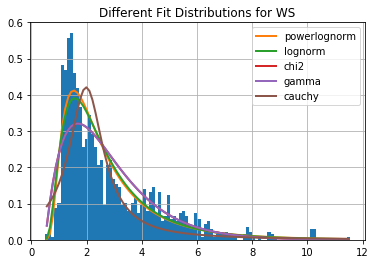

          sumsquare_error         aic           bic
exponpow         0.001675  947.761574 -16707.610786
norm             0.002183  951.192576 -16387.389255
lognorm          0.002227  954.219899 -16355.162858
gamma            0.002349  953.555793 -16289.563862
chi2             0.002372  951.555758 -16277.239691
Best Fit Method: {'exponpow': (2.4468278835610056, 8.880359521225955, 64.40467557606948)}


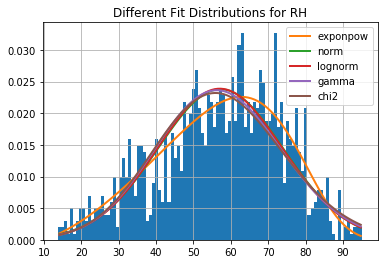

              sumsquare_error         aic           bic
lognorm              0.004641  892.146219 -15446.217617
powerlognorm         0.004643  876.757044 -15438.622654
norm                 0.004651  886.181722 -15450.659015
gamma                0.004792  890.833495 -15406.696897
chi2                 0.005088  890.326424 -15332.563844
Best Fit Method: {'lognorm': (0.009508332971985091, -926.1030628314529, 944.0342047376607)}


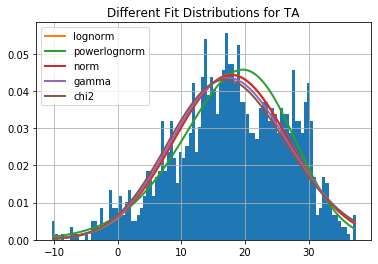

              sumsquare_error        aic          bic
exponpow            28.810330  64.542043 -4634.158066
powerlognorm        32.012044  75.925963 -4496.578614
chi2                32.252368  79.853860 -4494.440533
gamma               32.803027  75.547770 -4473.482042
lognorm             32.974628  74.034934 -4467.022630
Best Fit Method: {'exponpow': (2.540561614608289, -0.050329595957979006, 0.7545123739396357)}


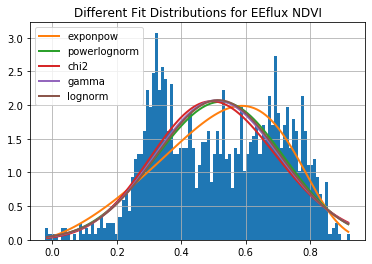

              sumsquare_error          aic          bic
cauchy             218.456527   300.682433 -2133.273283
lognorm            291.461287  1355.981531 -1769.211676
powerlognorm       291.636569  1355.906669 -1761.346128
gamma              308.849925  1621.960560 -1697.471695
chi2               308.850179  1621.959864 -1697.470678
Best Fit Method: {'cauchy': (0.17261693556308746, 0.015992325621843335)}


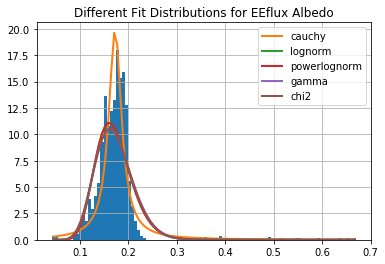

         sumsquare_error         aic           bic
norm            0.002942  926.605151 -16017.883396
lognorm         0.003065  929.956644 -15959.994496
gamma           0.003137  929.189030 -15931.348149
chi2            0.003372  931.749774 -15841.835813
cauchy          0.005366  950.765496 -15273.657456
Best Fit Method: {'norm': (297.69856219709214, 11.233071163088784)}


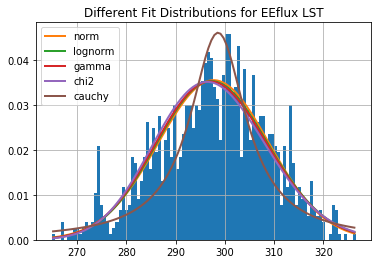

              sumsquare_error         aic          bic
powerlognorm       118.920119  344.936184 -2871.901949
lognorm            122.161680  337.522327 -2845.729153
gamma              127.566708  468.872948 -2792.131172
chi2               127.567204  468.867746 -2792.126358
rayleigh           153.509759  876.582122 -2570.068025
Best Fit Method: {'powerlognorm': (0.04607392227952459, 0.12364588165248058, -0.1173422475772147, 0.10623559115728433)}


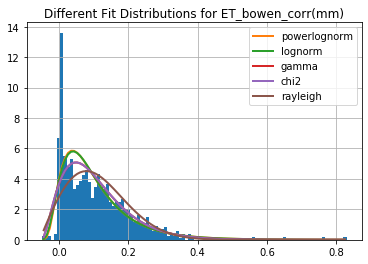

          sumsquare_error           aic           bic
expon            0.000759  18018.655329 -17694.780158
cauchy           0.008294   2257.262862 -14734.688376
chi2             0.020107   2721.504797 -13631.255466
exponpow         0.020258   6698.644001 -13621.937630
rayleigh         0.023563  38685.788071 -13442.008591
Best Fit Method: {'expon': (0.0, 2.463068243491115)}


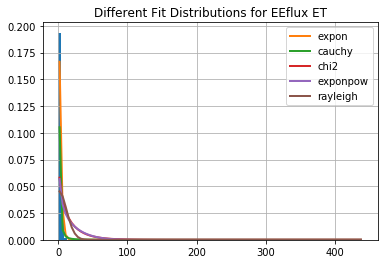

In [14]:
columnsToFit = ["WS", "RH", "TA", "EEflux NDVI", "EEflux Albedo", "EEflux LST",
                observed_variable, predicted_variable]
distributionsToFit = get_common_distributions() + ['powerlognorm']
print("Common Distributions are:", distributionsToFit)


def fit_distributions(column):
    f = Fitter(df[column], distributions=distributionsToFit, verbose=False)
    f.fit()
    print(f.summary()[["sumsquare_error", "aic", "bic"]])
    print("Best Fit Method:", f.get_best())
    plt.title('Different Fit Distributions for ' + column) 
    plt.show()
    plt.close()
  
for column in columnsToFit:
    fit_distributions(column)  

In [15]:
df_all[columnsToFit].describe()

WS           RH           TA  EEflux NDVI  EEflux Albedo  \
count  1238.000000  1238.000000  1238.000000  1238.000000    1238.000000   
mean      2.801679    57.251551    17.863509     0.516830       0.171652   
std       1.739122    16.771174     8.997996     0.192394       0.046622   
min       0.506093    13.723778   -10.398958    -0.022000       0.042000   
25%       1.487500    46.714805    11.989019     0.347250       0.152000   
50%       2.196896    58.783260    18.040057     0.519000       0.172000   
75%       3.721021    69.816708    24.968769     0.687000       0.188000   
max      11.530462    95.191667    37.448571     0.924000       0.670000   

        EEflux LST  ET_bowen_corr(mm)    EEflux ET  
count  1238.000000        1238.000000  1238.000000  
mean    297.698562           0.104899     2.463068  
std      11.237611           0.101056    12.978651  
min     264.820000          -0.049135     0.000000  
25%     290.070000           0.024068     0.000000  
50%     298.270000           0.083246     1.137280  
75%     305.640000           0.156983     3.226368  
max     326.580000           0.829548   439.272797